In [ ]:
import pathlib
import pandas as pd


# folder = pathlib.Path('./Kickstarter_2025-10-13T07_42_31_884Z')
# csv_files = folder.glob('Kickstarter*.csv')
# file_path = pathlib.Path('./Kickstarter_2025-10-13T07_42_31_884Z/Kickstarter_merged.csv')
# if file_path.exists():
#     print("File already exists")
# else:    
#     dfs = []
#     for p in csv_files:
#         try:
#             df = pd.read_csv(p)
#             df['source_file'] = p.name
#             dfs.append(df)
#         except Exception as e:
#             print("Failed")

#         merged = pd.concat(dfs, ignore_index=True)
#         out_path = folder / 'Kickstarter_merged.csv'
#         merged.to_csv(out_path, index=False)
#         print(f"Wrote merged CSV to {out_path} with {merged.shape[0]} rows and {merged.shape[1]} columns")



In [240]:
from ast import literal_eval
import numpy as np
#######################
#######################
# DATA PREPROCESSING
#######################
#######################
data_df = pd.read_csv('./Kickstarter_2025-10-13T07_42_31_884Z/Kickstarter_merged.csv')

data_df.drop(columns=['creator', 'country_displayable_name', 'currency_symbol', 'currency_trailing_code', 'current_currency', 
                            'disable_communication', 'photo', 'profile', 'source_url', 'urls'])
data_df = data_df[(data_df.state == "successful") | (data_df.state == "failed")]

data_df.drop_duplicates(subset=['id', 'state'], inplace=True)
# Converting datetime objects
data_df['created_at'] = data_df['created_at'].astype(int)
data_df['created_at'] = pd.to_datetime(data_df['created_at'],unit='s')
data_df['deadline'] = data_df['deadline'].astype(int)
data_df['deadline'] = pd.to_datetime(data_df['deadline'], unit='s')
data_df['launched_at'] = data_df['launched_at'].astype(int)
data_df['launched_at'] = pd.to_datetime(data_df['launched_at'],unit='s')
data_df['state_changed_at'] = data_df['state_changed_at'].astype(int)
data_df['state_changed_at'] = pd.to_datetime(data_df['state_changed_at'],unit='s')
category = data_df.category.apply(literal_eval)
main_category = []
for i, data in enumerate(category):
    try:
        main_category.append(data['parent_name'])
    except:
        main_category.append(np.nan)
data_df['main_category'] = main_category
print(data_df.main_category.value_counts())
sub_category = []
for i, name in enumerate(d['name'] for d in category):
    sub_category.append(name)
data_df['sub_category'] = sub_category
data_df.main_category.fillna(data_df.sub_category, inplace=True)
print(data_df.sub_category.value_counts())
data_df['goal'] = data_df.goal.astype(float)
data_df['fx_rate'] = data_df.fx_rate.astype(float)
data_df['goal_usd'] = data_df.goal * data_df.fx_rate

data_df.info()

ks = data_df[['id', 'goal_usd', 'country', 'created_at', 'deadline',  'launched_at', 'state_changed_at',
                  'spotlight','staff_pick', 'main_category', 'sub_category', 'blurb', 'state']]

ks.to_csv("./dist/process_ks.csv", index= False)


main_category
Film & Video    9598
Music           9156
Publishing      7632
Art             6081
Technology      6068
Food            5700
Games           4910
Fashion         3863
Design          3093
Photography     2776
Comics          2768
Crafts          2471
Theater         2405
Journalism      1747
Dance            962
Name: count, dtype: int64
sub_category
Tabletop Games    2235
Web               1338
Product Design    1238
Comedy            1220
Comic Books       1081
                  ... 
Fashion             12
Publishing          10
Film & Video         9
Games                8
Taxidermy            6
Name: count, Length: 161, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 70694 entries, 0 to 87492
Data columns (total 46 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   backers_count                       70694 non-null  int64         
 1   blurb          

/var/folders/43/5fgbl97x0ps7q234n55l5jg40000gn/T/ipykernel_3701/2103204791.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df.main_category.fillna(data_df.sub_category, inplace=True)


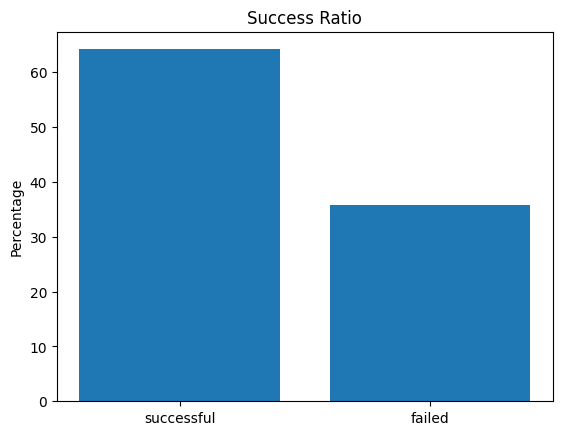

In [241]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

process_df= pd.read_csv('./dist/process_ks.csv')
target = process_df.state.value_counts(normalize=True) 
plt.figure()
plt.bar(target.index, target.values)
plt.title('Success Ratio')
plt.ylabel('Percentage')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _pos: f'{x * 100:.0f}'))



In [242]:
process_df['state'] = process_df.state.astype(str)
process_df['success'] = np.where(process_df.state == "successful", 1, 0)
process_df.success.value_counts()
process_df.head()

,id,goal_usd,country,created_at,deadline,launched_at,state_changed_at,spotlight,staff_pick,main_category,sub_category,blurb,state,success
0,905454355,5000.00000,US,2017-02-05 21:31:30,2017-03-31 16:34:32,2017-03-01 17:34:32,2017-03-31 16:34:32,True,True,Publishing,Radio & Podcasts,A largely-female podcast production team launc...,successful,1
1,1355380918,6300.00000,US,2016-12-30 03:30:54,2017-02-15 04:59:00,2017-01-27 22:38:43,2017-02-15 04:59:02,True,False,Publishing,Radio & Podcasts,I'm telling you...something happens when you p...,successful,1
2,1990443310,12500.00000,US,2017-01-23 00:30:47,2017-02-25 17:44:49,2017-01-26 17:44:49,2017-02-25 17:44:49,True,True,Publishing,Radio & Podcasts,Help The Pen Addict record live in Atlanta and...,successful,1
3,1482099881,11620.71830,FR,2021-10-05 19:27:32,2021-12-10 23:19:43,2021-11-08 23:19:43,2021-12-10 23:19:43,True,True,Photography,Photobooks,Photo book on the youth from neighborhoods in ...,successful,1
4,1486408077,10682.81912,GB,2021-11-04 20:27:52,2021-12-19 20:00:00,2021-11-08 20:50:45,2021-12-19 20:00:01,True,True,Photography,People,Photography book exploring northern England's ...,successful,1


Text(0, 0.5, 'Goal (USD)')

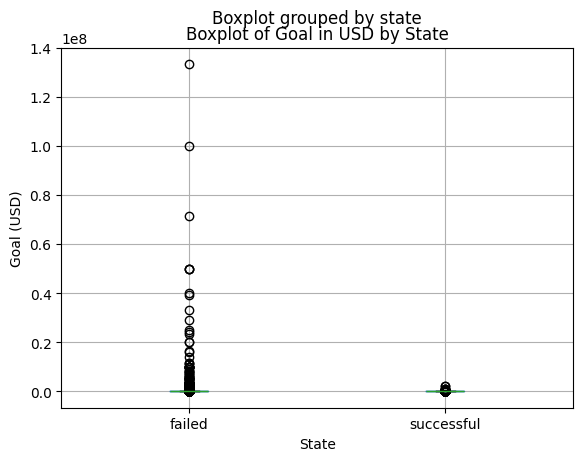

In [243]:
process_df.boxplot(column='goal_usd', by='state', vert=True)
plt.title('Boxplot of Goal in USD by State')
plt.xlabel('State')
plt.ylabel('Goal (USD)')


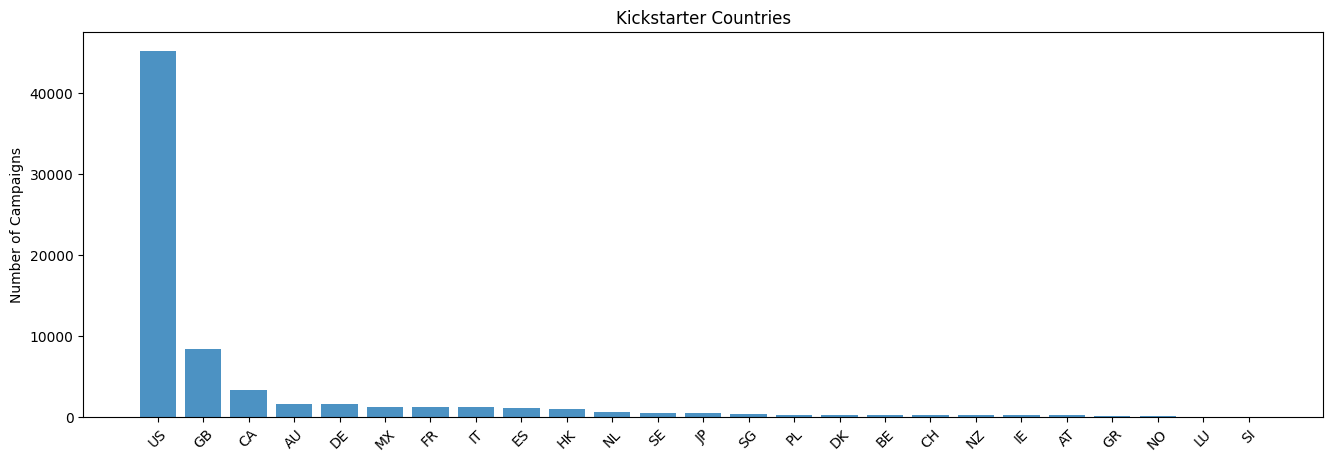

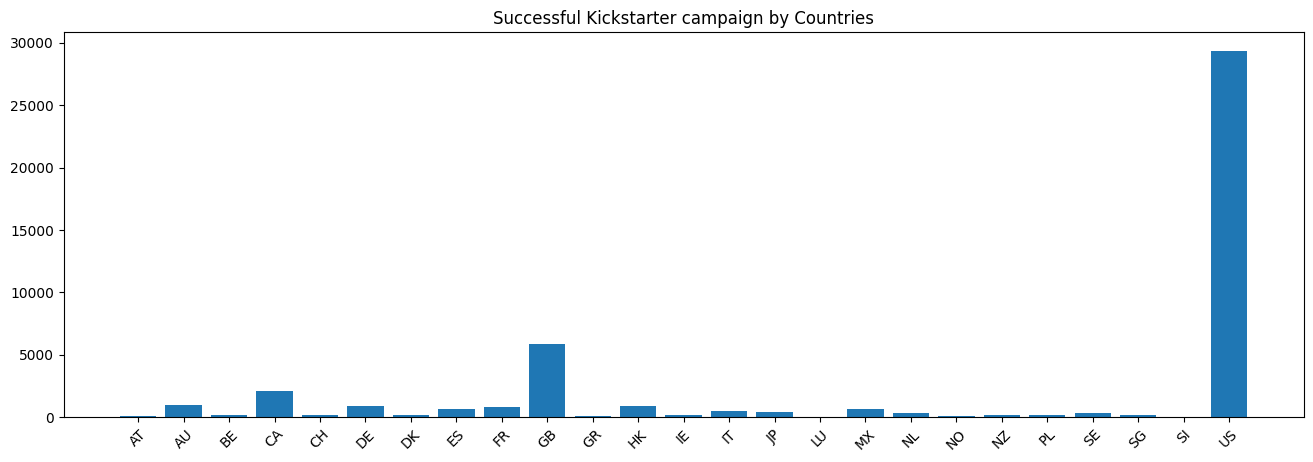

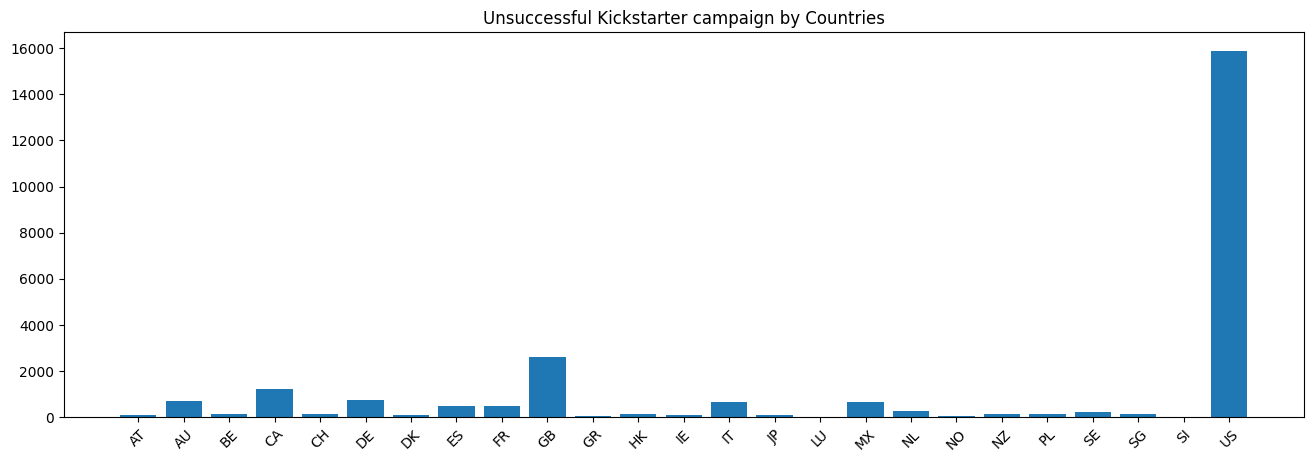

In [244]:
country_list = process_df.country.value_counts()
plt.figure(figsize=(16,5))
plt.bar(country_list.index, country_list.values, alpha=0.8)
plt.title('Kickstarter Countries')
plt.ylabel('Number of Campaigns');
plt.xticks(rotation=45);


country_success = process_df[process_df['state'] == 'successful'].groupby(['country']).size()
plt.figure(figsize=(16,5))
plt.bar(country_success.index, country_success.values)
plt.title('Successful Kickstarter campaign by Countries')
plt.xticks(rotation=45);

country_success = process_df[process_df['state'] != 'successful'].groupby(['country']).size()
plt.figure(figsize=(16,5))
plt.bar(country_success.index, country_success.values)
plt.title('Unsuccessful Kickstarter campaign by Countries')
plt.xticks(rotation=45);

process_df['country_US'] = np.where(process_df.country == "US", 1, 0)

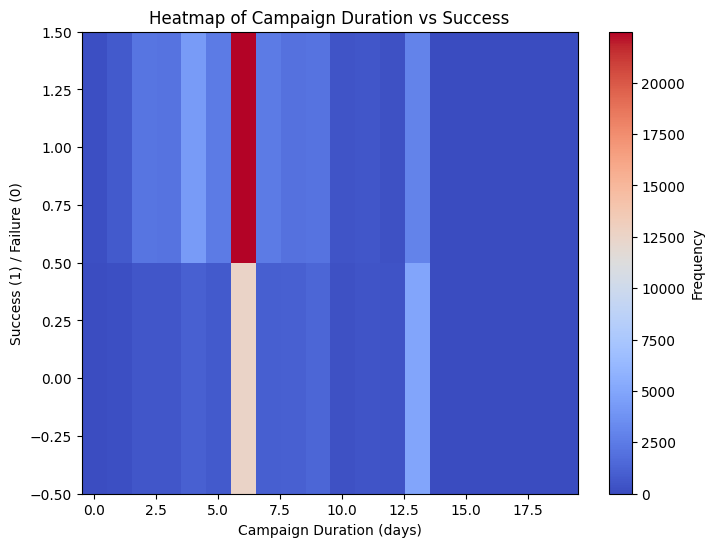

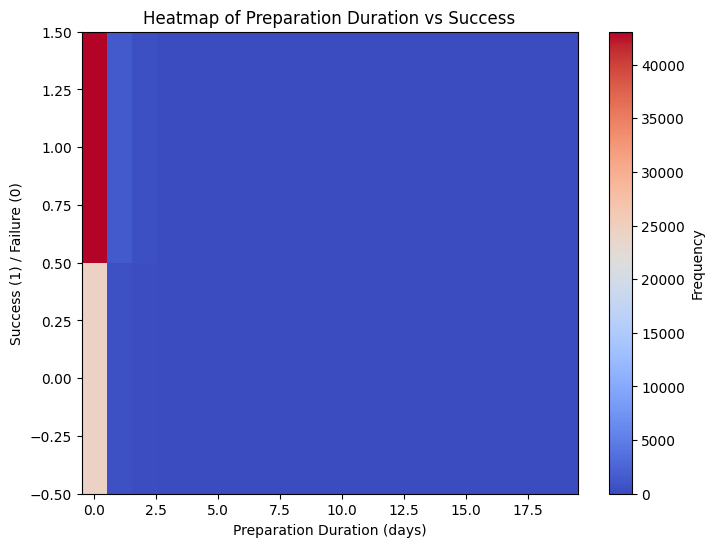

In [245]:
process_df['created_at'] = pd.to_datetime(process_df.created_at)
process_df['launched_at'] = pd.to_datetime(process_df.launched_at)
process_df['deadline'] = pd.to_datetime(process_df.deadline)

prep_date = process_df.created_at.values
start_date = process_df.launched_at.values
end_date = process_df.deadline.values

# campaign duration = from launched time to deadline
process_df['cam_duration'] = pd.to_timedelta(end_date - start_date).days
process_df['prep_duration'] = pd.to_timedelta(start_date - prep_date).days

success_mapping = process_df['state'].map({'successful': 1, 'failed': 0})
heatmap_data = np.histogram2d(process_df['cam_duration'], success_mapping, bins=(20, 2))

plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data[0].T, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(label='Frequency')
plt.xlabel('Campaign Duration (days)')
plt.ylabel('Success (1) / Failure (0)')
plt.title('Heatmap of Campaign Duration vs Success')
plt.show()

heatmap_data = np.histogram2d(process_df['prep_duration'], success_mapping, bins=(20, 2))

plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data[0].T, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(label='Frequency')
plt.xlabel('Preparation Duration (days)')
plt.ylabel('Success (1) / Failure (0)')
plt.title('Heatmap of Preparation Duration vs Success')
plt.show()

main_category
Art             4544
Comics          2332
Crafts          1377
Dance           1066
Design          2166
Fashion         2232
Film & Video    6455
Food            2361
Games           3592
Journalism       853
Music           6828
Photography     1653
Publishing      5052
Technology      3202
Theater         1644
dtype: int64


Index(['id', 'goal_usd', 'country', 'created_at', 'deadline', 'launched_at',
       'state_changed_at', 'spotlight', 'staff_pick', 'sub_category', 'blurb',
       'state', 'success', 'country_US', 'cam_duration', 'prep_duration',
       'main_category_Comics', 'main_category_Crafts', 'main_category_Dance',
       'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater'],
      dtype='object')

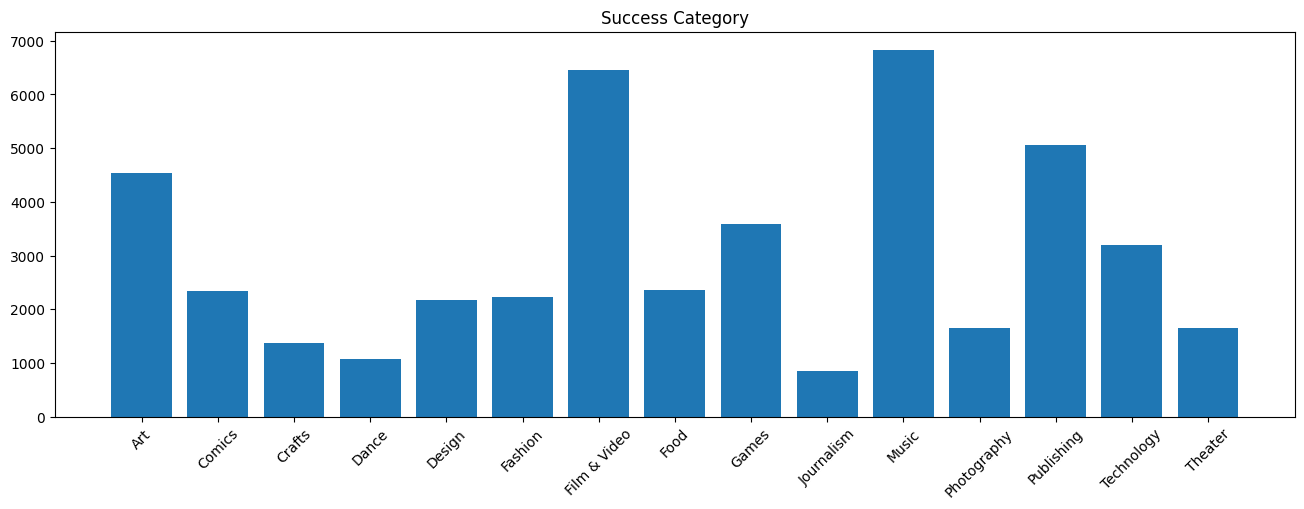

In [246]:
category_success = process_df[process_df['success'] == 1].groupby(['main_category']).size()
print(category_success)
plt.figure(figsize=(16,5))
plt.bar(category_success.index, category_success.values)
plt.title('Success Category')
plt.xticks(rotation=45);

process_df = pd.get_dummies(columns=['main_category'],dtype=int, drop_first=True, data=process_df)
process_df.columns

In [247]:
process_df.rename(columns={'main_category_Comics': 'Comics',
                   'main_category_Crafts': 'Crafts', 
                   'main_category_Dance': 'Dance', 
                   'main_category_Design': 'Design',
                   'main_category_Fashion': 'Fashion', 
                   'main_category_Film & Video': 'Film_Video',
                   'main_category_Food': 'Food', 
                   'main_category_Games': 'Games', 
                   'main_category_Journalism': 'Journalism',
                   'main_category_Music': 'Music', 
                   'main_category_Photography': 'Photography',
                   'main_category_Publishing': 'Publishing', 
                   'main_category_Technology': 'Technology',
                   'main_category_Theater': 'Theater'}, inplace=True)
process_df.columns


Index(['id', 'goal_usd', 'country', 'created_at', 'deadline', 'launched_at',
       'state_changed_at', 'spotlight', 'staff_pick', 'sub_category', 'blurb',
       'state', 'success', 'country_US', 'cam_duration', 'prep_duration',
       'Comics', 'Crafts', 'Dance', 'Design', 'Fashion', 'Film_Video', 'Food',
       'Games', 'Journalism', 'Music', 'Photography', 'Publishing',
       'Technology', 'Theater'],
      dtype='object')

In [248]:
import seaborn as sns

def make_confusion_matrix(model, threshold=0.6):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test_sc)[:,1] >=threshold)
    success_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(success_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['fail','success'],
           yticklabels=['fail','success']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [249]:
# baselining with small subset of features
subset_1 = process_df.loc[:,['success', 'goal_usd', 'country_US', 'cam_duration','prep_duration',
       'Comics', 'Crafts', 'Dance', 'Design', 'Fashion', 'Film_Video', 'Food',
       'Games', 'Journalism', 'Music', 'Photography', 'Publishing',
       'Technology', 'Theater']]
subset_1.head()


,success,goal_usd,country_US,cam_duration,prep_duration,Comics,Crafts,Dance,Design,Fashion,Film_Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
0,1,5000.00000,1,29,23,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,6300.00000,1,18,28,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,12500.00000,1,30,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,11620.71830,0,32,34,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,10682.81912,0,40,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0


              precision    recall  f1-score   support

           0       0.65      0.33      0.43      4035
           1       0.71      0.90      0.79      7276

    accuracy                           0.70     11311
   macro avg       0.68      0.61      0.61     11311
weighted avg       0.69      0.70      0.66     11311

0.7133995216402929


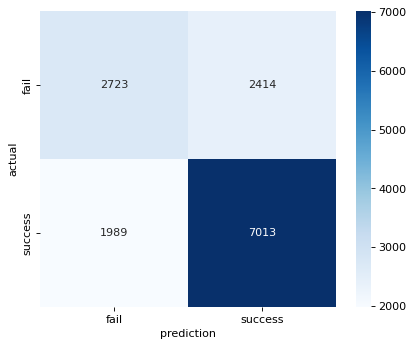

In [250]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import roc_curve, auc


X, y = subset_1.drop(['success'], axis=1), subset_1.success

X_mid, X_test, y_mid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_mid, y_mid, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_sc, y_train)
lr_pred = lr.predict(X_val_sc)

lr_ac = lr.score(X_val_sc, y_val)
lr_precision = precision_score(y_val, lr_pred)
lr_recall = recall_score(y_val, lr_pred)
lr_f1 = f1_score(y_val, lr_pred)

print(classification_report(y_val, lr_pred))
make_confusion_matrix(lr)
lr_y_score = lr.predict_proba(X_val_sc)[:,1]
lr_fpr, lr_tpr, lr_auc_thresholds = roc_curve(y_val, lr_y_score)
roc_auc_lr = auc(lr_fpr, lr_tpr)
print(roc_auc_lr)

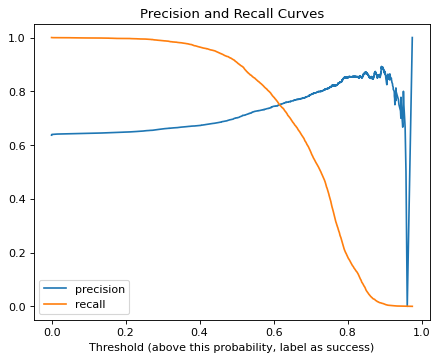

In [251]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lr.predict_proba(X_test_sc)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as success)');
plt.title('Precision and Recall Curves');

              precision    recall  f1-score   support

           0       0.52      0.54      0.53      4035
           1       0.74      0.72      0.73      7276

    accuracy                           0.66     11311
   macro avg       0.63      0.63      0.63     11311
weighted avg       0.66      0.66      0.66     11311

Decision Tree validation metrics: 
 Accuracy: 0.6591 
 Precision: 0.7406 
 Recall: 0.7235 
 F1: 0.7319
0.6347675268557897


/Users/duahau1/CS533/CProject/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


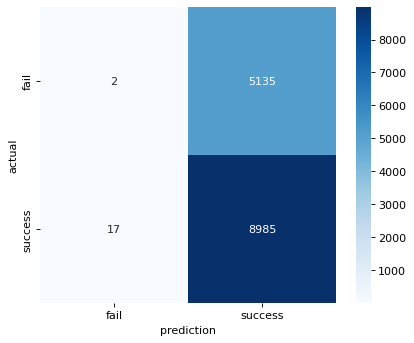

In [252]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_val)

dt_ac = dt.score(X_val, y_val)
dt_precision = precision_score(y_val, dt_pred)
dt_recall = recall_score(y_val, dt_pred)
dt_f1 = f1_score(y_val, dt_pred)

print(classification_report(y_val, dt_pred))

print('Decision Tree validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (dt_ac, 
         dt_precision, 
         dt_recall,
         dt_f1)
     )

make_confusion_matrix(dt)
dt_y_score = dt.predict_proba(X_val)[:, 1]
dt_fpr, dt_tpr, auc_thresholds = roc_curve(y_val, dt_y_score)
roc_auc_dt = auc(dt_fpr, dt_tpr)
print(roc_auc_dt)

              precision    recall  f1-score   support

           0       0.61      0.52      0.56      4035
           1       0.75      0.82      0.78      7276

    accuracy                           0.71     11311
   macro avg       0.68      0.67      0.67     11311
weighted avg       0.70      0.71      0.71     11311

Random Forest validation metrics: 
 Accuracy: 0.7113 
 Precision: 0.7536 
 Recall: 0.8189 
 F1: 0.7849


/Users/duahau1/CS533/CProject/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.7383908870500221


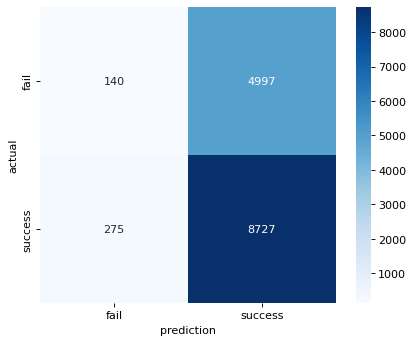

In [253]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)
rf_confusion = confusion_matrix(y_val, rf_pred)

rf_ac = rf.score(X_val, y_val)
rf_precision = precision_score(y_val, rf_pred)
rf_recall = recall_score(y_val, rf_pred)
rf_f1 = f1_score(y_val, rf_pred)

print(classification_report(y_val, rf_pred))
print('Random Forest validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (rf_ac, 
         rf_precision, 
         rf_recall,
         rf_f1)
     )
make_confusion_matrix(rf)
rf_y_score = rf.predict_proba(X_val)[:, 1]
rf_fpr, rf_tpr, auc_thresholds = roc_curve(y_val, rf_y_score)
roc_auc_rf = auc(rf_fpr, rf_tpr)
print(roc_auc_rf)

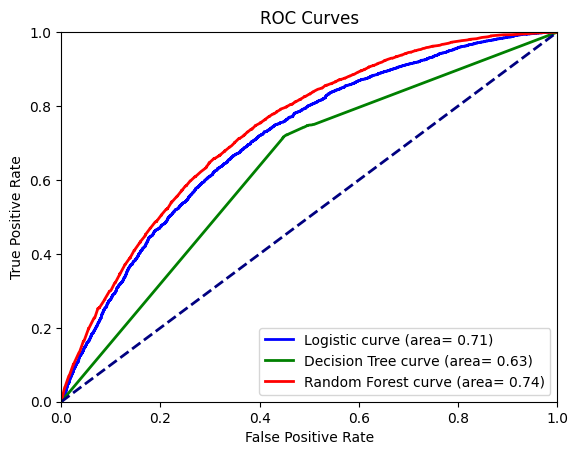

In [254]:
plt.plot(lr_fpr, lr_tpr, color='blue', lw=lw, 
         label='Logistic curve (area= %0.2f)' %roc_auc_lr)
plt.plot(dt_fpr, dt_tpr, color='green', lw=lw, 
         label='Decision Tree curve (area= %0.2f)' %roc_auc_dt)
plt.plot(rf_fpr, rf_tpr, color='red', lw=lw, 
         label='Random Forest curve (area= %0.2f)' %roc_auc_rf)
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right');

In [255]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X_mid)
X_test_sc = scaler.transform(X_test)
##Logistic Regression
lr.fit(X_sc, y_mid)
lr_pred = lr.predict(X_test_sc)

lr_ac = lr.score(X_test_sc, y_test)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)

lr_y_score = lr.predict_proba(X_test_sc)[:,1]
lr_fpr, lr_tpr, lr_auc_thresholds = roc_curve(y_test, lr_y_score)
roc_auc_lr = auc(lr_fpr, lr_tpr)

##Decision Tree
dt.fit(X_mid, y_mid)
dt_pred = dt.predict(X_test)

dt_ac = dt.score(X_test, y_test)
dt_precision = precision_score(y_test, dt_pred)
dt_recall = recall_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)

dt_y_score = dt.predict_proba(X_test)[:, 1]
dt_fpr, dt_tpr, auc_thresholds = roc_curve(y_test, dt_y_score)
roc_auc_dt = auc(dt_fpr, dt_tpr)

##Random Forest
rf.fit(X_mid, y_mid)
rf_pred = rf.predict(X_test)
rf_confusion = confusion_matrix(y_test, rf_pred)

rf_ac = rf.score(X_test, y_test)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

rf_y_score = rf.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, auc_thresholds = roc_curve(y_test, rf_y_score)
roc_auc_rf = auc(rf_fpr, rf_tpr)


col_list = ['Model_type','accuracy', 'precision', 'recall', 'f1', 'roc']
lr_dict = dict(zip(col_list, ['Logistic', lr_ac, lr_precision, lr_recall, lr_f1, roc_auc_lr]))
dt_dict = dict(zip(col_list, ['Decision Tree', dt_ac, dt_precision, dt_recall, dt_f1, roc_auc_dt]))
rf_dict = dict(zip(col_list, ['Random Forest', rf_ac, rf_precision, rf_recall, rf_f1, roc_auc_rf]))

score_df = pd.DataFrame([lr_dict, dt_dict, rf_dict])
score_df

,Model_type,accuracy,precision,recall,f1,roc
0,Logistic,0.696089,0.702470,0.906687,0.791620,0.714926
1,Decision Tree,0.645661,0.726921,0.710287,0.718508,0.622017
2,Random Forest,0.707405,0.744841,0.822040,0.781539,0.732731


In [256]:
import pickle
filename = 'random_forest_model.pkl'
pickle.dump(rf, open(filename, 'wb'))
